In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
from numba import njit, prange

import sys
sys.path.append('../')

import lib.fun_plotting as fun_plotting
from lib.ml_wrapper import asynch_reconstruction

from lib.hmm_wrapper import binomial_HMM

In [2]:
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

In [3]:
data_discrete = np.load('experimental_data/data_discrete.npy')

In [49]:
# augment data by artificially repeating it

spins = np.hstack([data_discrete]*50)

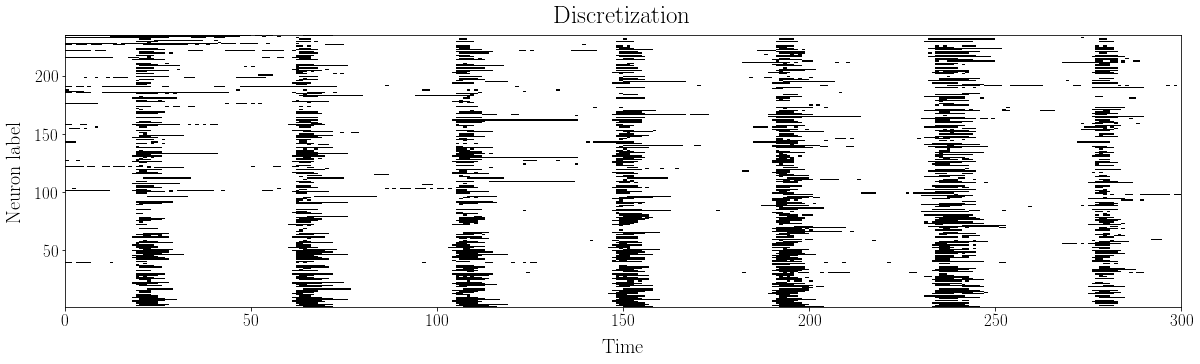

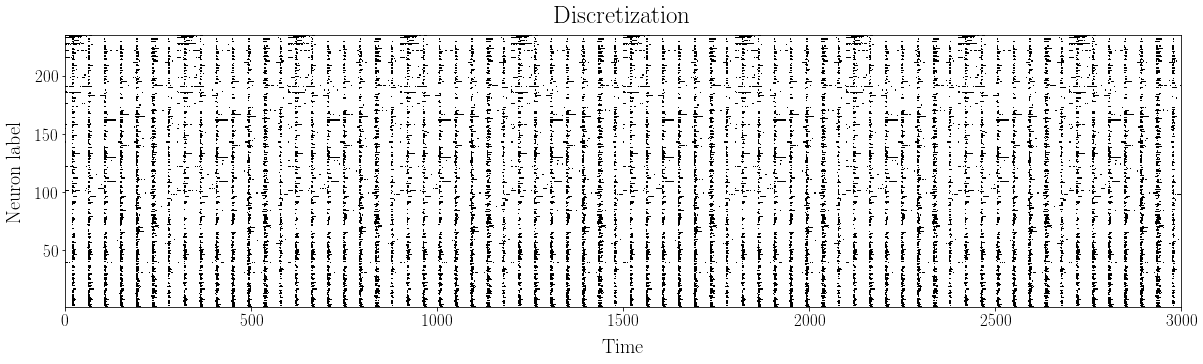

In [50]:
fun_plotting.raster_plot(data_discrete, 'Discretization', delta_t = 1)
plt.show()

fun_plotting.raster_plot(spins, 'Discretization', delta_t = 1)
plt.show()

In [212]:
# initialize the reconstruction
Nepochs = 800
LAMBDA = 0.05
lr = 0.5
drop = 0.8
edrop = 20

model = asynch_reconstruction(spins, delta_t = 1, LAMBDA = LAMBDA, opt = 'NADAM', reg = 'L1')

Epoch 	 Max J gradient 	 Max h gradient 	 Max change in J 	 Max change in h 	 Likelihood
25 	 0.822491 	 0.82263 	 0.274 	 0.1241 	 -57.3678
50 	 0.272935 	 0.260059 	 0.1826 	 0.1195 	 -31.5192
75 	 0.668166 	 0.667602 	 0.1577 	 0.0896 	 -20.5758
100 	 0.363862 	 0.337791 	 0.0846 	 0.0531 	 -14.4521
125 	 0.135735 	 0.135033 	 0.0577 	 0.0172 	 -11.2324
150 	 0.049532 	 0.020107 	 0.0309 	 0.0065 	 -9.288
175 	 0.018426 	 0.00151 	 0.0146 	 0.0054 	 -8.1263
200 	 0.009377 	 0.001507 	 0.0077 	 0.0037 	 -7.3651
225 	 0.006454 	 0.00151 	 0.0059 	 0.0032 	 -6.8666
250 	 0.00602 	 0.001512 	 0.0046 	 0.0027 	 -6.5157
275 	 0.006022 	 0.001514 	 0.0036 	 0.0023 	 -6.2646
300 	 0.006015 	 0.001515 	 0.0023 	 0.0016 	 -6.0828
325 	 0.006003 	 0.001515 	 0.0018 	 0.0014 	 -5.955
350 	 0.005989 	 0.001515 	 0.0015 	 0.0012 	 -5.8599
375 	 0.005975 	 0.001514 	 0.0012 	 0.001 	 -5.7887
400 	 0.005962 	 0.001513 	 0.0008 	 0.0007 	 -5.7352
425 	 0.00595 	 0.001512 	 0.0006 	 0.0006 	 -5.6965


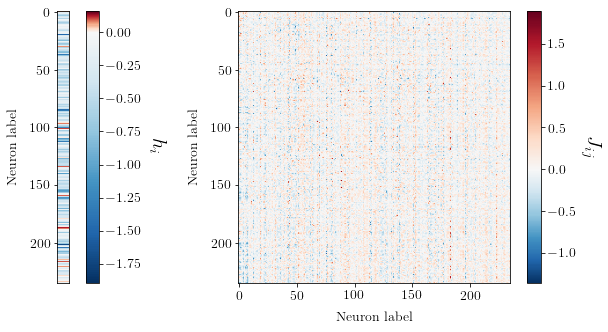

In [213]:
# reconstruct the model using gradient ascent

model.reconstruct(spins, Nepochs = Nepochs, start_lr = lr, drop = drop, edrop = edrop)

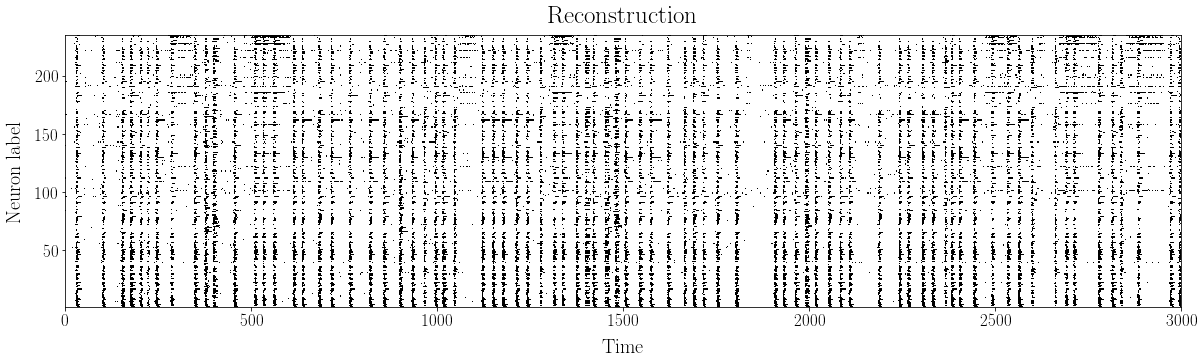

In [218]:
spins_new = model.generate_samples()
fun_plotting.raster_plot(spins_new, 'Reconstruction', delta_t = 1)
plt.show()

In [219]:
np.save('model_parameters/J'+str(Nepochs)+'_'+str(LAMBDA)+'_'+str(lr)+'_'+str(drop)+'_'+str(edrop)+'.npy', model.J)
np.save('model_parameters/h'+str(Nepochs)+'_'+str(LAMBDA)+'_'+str(lr)+'_'+str(drop)+'_'+str(edrop)+'.npy', model.h)

In [220]:
spins_new[spins_new == -1] = 0
spins_new = spins_new[:,~np.all(spins_new == 0, axis = 0)]
N_neurons = spins_new.shape[0]
N_hidden = 2

data_discrete[data_discrete == -1] = 0
data_discrete = data_discrete[:,~np.all(data_discrete == 0, axis = 0)]

In [221]:
hmm_rec = binomial_HMM(N_hidden, N_neurons)
hmm_data = binomial_HMM(N_hidden, N_neurons)

for _ in range(10):
    hmm_rec.update(spins_new.T)
    print()
    
for _ in range(10):
    hmm_data.update(data_discrete.T)
    print()

	 Current log-likelihood: -653968.44
Best log-likelihood!

	 Current log-likelihood: -198582.25
Best log-likelihood!

	 Current log-likelihood: -135457.36
Best log-likelihood!

	 Current log-likelihood: -133414.92
Best log-likelihood!

	 Current log-likelihood: -133338.97
Best log-likelihood!

	 Current log-likelihood: -133338.12
Best log-likelihood!

	 Current log-likelihood: -133337.99
Best log-likelihood!

	 Current log-likelihood: -133337.98
Best log-likelihood!

	 Current log-likelihood: -133337.98
Best log-likelihood!

	 Current log-likelihood: -133337.98
Best log-likelihood!

	 Current log-likelihood: -63212.84
Best log-likelihood!

	 Current log-likelihood: -14549.71
Best log-likelihood!

	 Current log-likelihood: -13464.68
Best log-likelihood!

	 Current log-likelihood: -13413.77
Best log-likelihood!

	 Current log-likelihood: -13391.28
Best log-likelihood!

	 Current log-likelihood: -13391.28
Best log-likelihood!

	 Current log-likelihood: -13391.28
Best log-likelihood!

	 Cu

In [222]:
hmm_rec.sort_states()
hmm_data.sort_states()

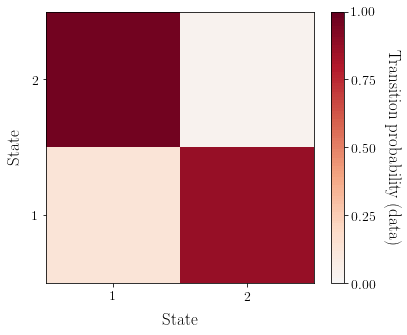

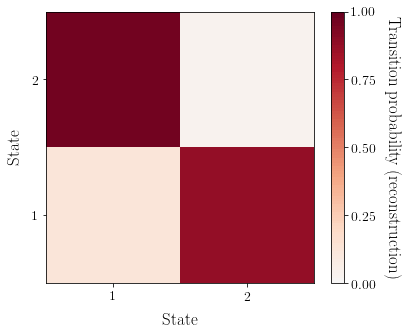

In [223]:
fig, ax = fun_plotting.plot_probability_mat(np.exp(hmm_data.best_log_transition_matrix),
                                            'Transition probability (data)', Ymax = N_hidden, Xmax = N_hidden)
ax.set_xlabel('State', fontsize = 17, labelpad = 10)
ax.set_ylabel('State', fontsize = 17, labelpad = 10)
plt.show()

fig, ax = fun_plotting.plot_probability_mat(np.exp(hmm_rec.best_log_transition_matrix),
                                            'Transition probability (reconstruction)', Ymax = N_hidden, Xmax = N_hidden)
ax.set_xlabel('State', fontsize = 17, labelpad = 10)
ax.set_ylabel('State', fontsize = 17, labelpad = 10)
plt.show()

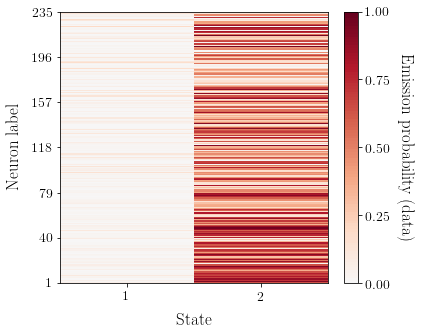

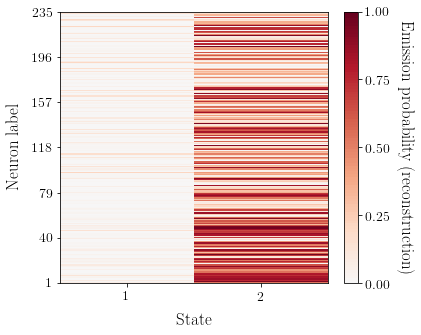

In [224]:
fig, ax = fun_plotting.plot_probability_mat(np.exp(hmm_data.best_log_emission_matrix).T,
                                            'Emission probability (data)', Ymax = N_neurons, Xmax = N_hidden)
ax.set_xlabel('State', fontsize = 17, labelpad = 10)
ax.set_ylabel('Neuron label', fontsize = 17, labelpad = 10)
ax.set_yticks(np.linspace(1, N_neurons, 7).astype('int'))
plt.show()

fig, ax = fun_plotting.plot_probability_mat(np.exp(hmm_rec.best_log_emission_matrix).T,
                                            'Emission probability (reconstruction)', Ymax = N_neurons, Xmax = N_hidden)
ax.set_xlabel('State', fontsize = 17, labelpad = 10)
ax.set_ylabel('Neuron label', fontsize = 17, labelpad = 10)
ax.set_yticks(np.linspace(1, N_neurons, 7).astype('int'))
plt.show()

In [225]:
p = hmm_rec.states_probability
state_labels = ['Inactive', 'Active']
colors = ['lightskyblue', 'orangered']

stateseq = np.argmax(p, axis = 1)

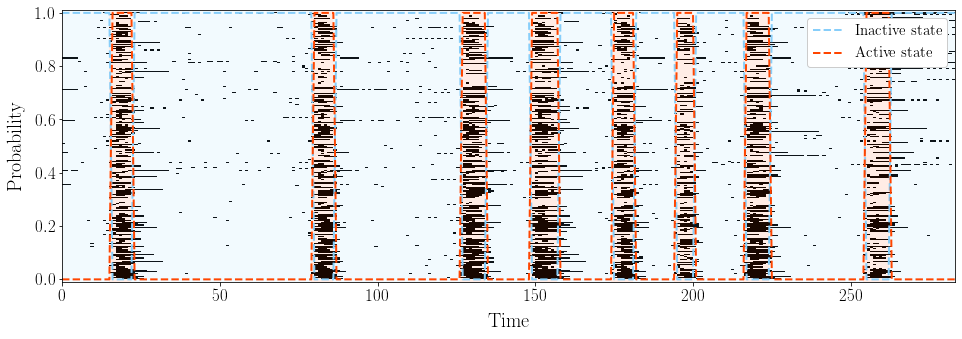

In [226]:
xmin = 0
xmax = 284

fun_plotting.plot_state_sequence(p, spins_new, state_labels, colors, xmin, xmax, delta_t = 1)
plt.show()